<h1>M. Nielsen, Chapter 6, second cnn model</h1>

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
import os
import numpy as np
import time
import random
import tensorflow as tf

In [7]:
from matplotlib import pyplot as plt

In [9]:
os.chdir(r"C:\Users\mchen\OneDrive\桌面\ml\code\tutorial\chapter3\20211119\multi_layer")

In [11]:
import mnist_loader
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

In [13]:
###############################################
#    load data from local directory
###############################################

train_x, train_y, val_x, val_y, test_x, test_y = [], [], [], [], [], []

training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

for tra in training_data:
    img_tra_x = tra[0].reshape(28,28).tolist()
    img_tra_y = np.array(np.argmax(tra[1]), dtype=np.uint8)
    train_x.append(img_tra_x)
    train_y.append(img_tra_y)
print(np.shape(train_x))

for val in validation_data:
    img_val_x = val[0].reshape(28,28)
#     img_val_y = np.array(np.argmax(val[1]), dtype=np.uint8)
    img_val_y = np.array(val[1], dtype=np.uint8)
    val_x.append(img_val_x)
    val_y.append(img_val_y)
print(np.shape(val_x))

for tes in test_data:
    img_tes_x = tes[0].reshape(28,28)
    img_tes_y = np.array(tes[1], dtype=np.uint8)
    test_x.append(img_tes_x)
    test_y.append(img_tes_y)
print(np.shape(test_x))


train_x = np.array(train_x)
val_x = np.array(val_x)
test_x = np.array(test_x)

train_y = np.array(train_y)
val_y = np.array(val_y)
test_y = np.array(test_y)

(50000, 28, 28)
(10000, 28, 28)
(10000, 28, 28)


In [16]:
# ###############################################
# #    checking data format:
# ###############################################
# plt.imshow(train_x[0], interpolation='none')
# plt.show()
# print('img label:', train_y[0])

# plt.imshow(val_x[0], interpolation='none')
# plt.show()
# print('img label:', val_y[0])

# plt.imshow(test_x[0], interpolation='none')
# plt.show()
# print('img label:', test_y[0])


<h1>Trying Implementing the second CNN model as described in M. Nielsen, Chapter 6</h1>	

In [17]:
# >>> net = Network([
#         ConvPoolLayer(image_shape=(mini_batch_size, 1, 28, 28), 
#                       filter_shape=(20, 1, 5, 5), 
#                       poolsize=(2, 2)),
#         ConvPoolLayer(image_shape=(mini_batch_size, 20, 12, 12), 
#                       filter_shape=(40, 20, 5, 5), 
#                       poolsize=(2, 2)),
#         FullyConnectedLayer(n_in=40*4*4, n_out=100),
#         SoftmaxLayer(n_in=100, n_out=10)], mini_batch_size)
# >>> net.SGD(training_data, 60, mini_batch_size, 0.1, 
#             validation_data, test_data)      

<h1>Reshape data</h1>

In [18]:
# reshape data
train_x = train_x.reshape(np.shape(train_x)[0], np.shape(train_x)[1], np.shape(train_x)[2], 1)
val_x = val_x.reshape(np.shape(val_x)[0], np.shape(val_x)[1], np.shape(val_x)[2], 1)
test_x = test_x.reshape(np.shape(test_x)[0], np.shape(test_x)[1], np.shape(test_x)[2], 1)

train_y = tf.one_hot(train_y.astype(np.int32), depth=10)
val_y = tf.one_hot(val_y.astype(np.int32), depth=10)
test_y = tf.one_hot(test_y.astype(np.int32), depth=10)

<h1>Build Network model</h1>

In [19]:
################################################################
#   first CNN network as described in chapter 6
################################################################
tf.random.set_seed(42)
################################################################

################################################################
# construct netwoek model

input_shape = (28, 28, 1)

model = tf.keras.models.Sequential()

model.add(
    tf.keras.layers.Conv2D( # no padding
        20,
        (5,5),
        activation=tf.nn.sigmoid,
        input_shape=input_shape
    )
)

model.add(
    tf.keras.layers.MaxPool2D(
        strides=(2,2)
    )
)

model.add(
    tf.keras.layers.Conv2D( # no padding
        40,
        (5,5),
        activation=tf.nn.sigmoid,
    )
)

model.add(
    tf.keras.layers.MaxPool2D(
        strides=(2,2)
    )
)

model.add(
    tf.keras.layers.Flatten()
)

model.add(
    tf.keras.layers.Dense(
        100,
        activation=tf.nn.sigmoid,
        kernel_initializer=tf.keras.initializers.RandomNormal(
            stddev=1.0),
        bias_initializer=tf.keras.initializers.RandomNormal(
            stddev=1.0)
    )
)

model.add(
    tf.keras.layers.Dense(
        10,
        activation=tf.nn.softmax,
    )
)
################################################################

################################################################
# compile model
n_eph = 60
eta = 0.1
model.compile(
    optimizer=tf.keras.optimizers.SGD(
        learning_rate=eta,
        momentum=0.0,
        nesterov=False,
        name="SGD"),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

################################################################
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 20)        520       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 40)          20040     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 40)          0         
_________________________________________________________________
flatten (Flatten)            (None, 640)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               64100     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

<h1>Train Network</h1>

In [22]:
################################################################
# save the model when val_acc is best
checkpoint_filepath = r'C:\Users\mchen\OneDrive\桌面\ml\code\tutorial\chapter6\save_model\cnn2\cnn2'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
################################################################

################################################################
#    train model  (how do i randomize mini_batches?)
batch_size = 10
n_eph = 60

ts = time.time()
history = model.fit(
    train_x, train_y, 
    epochs=n_eph,
    batch_size=batch_size,
    validation_data=(val_x, val_y),
    callbacks=[model_checkpoint_callback],
    shuffle=True
)
te = time.time()

print('total time:', te - ts)


acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
################################################################


################################################################
#    load the weights for the best epoch (best val accuracy)
model.load_weights(checkpoint_filepath)

################################################################

################################################################
#    evaluate test data at the best epoch
[test_data_loss, test_data_accuracy] = model.evaluate(
    test_x, test_y,
    batch_size=len(test_x)
)
################################################################


Epoch 1/60
5000/5000 [==============================] - 29s 6ms/step - loss: 0.0034 - accuracy: 0.9998 - val_loss: 0.0485 - val_accuracy: 0.9880
Epoch 2/60
5000/5000 [==============================] - 29s 6ms/step - loss: 0.0032 - accuracy: 0.9998 - val_loss: 0.0491 - val_accuracy: 0.9875
Epoch 3/60
5000/5000 [==============================] - 29s 6ms/step - loss: 0.0030 - accuracy: 0.9998 - val_loss: 0.0487 - val_accuracy: 0.9879
Epoch 4/60
5000/5000 [==============================] - 29s 6ms/step - loss: 0.0027 - accuracy: 0.9998 - val_loss: 0.0485 - val_accuracy: 0.9879
Epoch 5/60
5000/5000 [==============================] - 28s 6ms/step - loss: 0.0024 - accuracy: 0.9999 - val_loss: 0.0489 - val_accuracy: 0.9878
Epoch 6/60
5000/5000 [==============================] - 29s 6ms/step - loss: 0.0023 - accuracy: 0.9999 - val_loss: 0.0492 - val_accuracy: 0.9875
Epoch 7/60
5000/5000 [==============================] - 29s 6ms/step - loss: 0.0022 - accuracy: 0.9999 - val_loss: 0.0495 - val_ac

5000/5000 [==============================] - 33s 7ms/step - loss: 5.1302e-04 - accuracy: 1.0000 - val_loss: 0.0530 - val_accuracy: 0.9883
Epoch 57/60
5000/5000 [==============================] - 33s 7ms/step - loss: 5.0527e-04 - accuracy: 1.0000 - val_loss: 0.0530 - val_accuracy: 0.9881
Epoch 58/60
5000/5000 [==============================] - 33s 7ms/step - loss: 4.9753e-04 - accuracy: 1.0000 - val_loss: 0.0533 - val_accuracy: 0.9880
Epoch 59/60
5000/5000 [==============================] - 33s 7ms/step - loss: 4.8801e-04 - accuracy: 1.0000 - val_loss: 0.0529 - val_accuracy: 0.9882
Epoch 60/60
5000/5000 [==============================] - 33s 7ms/step - loss: 4.8219e-04 - accuracy: 1.0000 - val_loss: 0.0531 - val_accuracy: 0.9882
total time: 1992.6532249450684
1/1 [==============================] - 1s 580ms/step - loss: 0.0355 - accuracy: 0.9895


<h2>plot the result</h2>

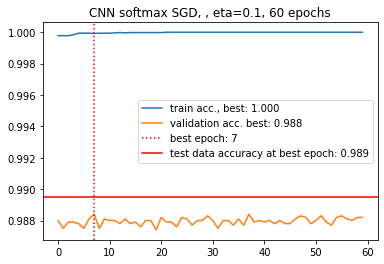

In [31]:
plt.plot(acc, label='train acc., best: {:.3f}'.format(max(acc)))
plt.plot(val_acc, label='validation acc. best: {:.3f}'.format(max(val_acc)))
plt.title('CNN softmax SGD, , eta={}, {} epochs'.format(eta, n_eph))
plt.axvline(x=np.argmax(val_acc), c='r', ls=':', label='best epoch: {}'.format(np.argmax(val_acc)))
plt.axhline(y=test_data_accuracy, c='r', label='test data accuracy at best epoch: {:.3f}'.format(test_data_accuracy))
plt.legend()
plt.show()

from winsound import Beep
Beep(1000, 100)

<h1>Max accuracy= 98.9%</h1>
<h1>Total time=1993s</h1>

In [33]:
print(acc)

[0.999779999256134, 0.999779999256134, 0.999779999256134, 0.9998400211334229, 0.9999399781227112, 0.9999399781227112, 0.9999399781227112, 0.9999200105667114, 0.9999399781227112, 0.9999399781227112, 0.9999399781227112, 0.9999600052833557, 0.9999799728393555, 0.9999600052833557, 0.9999799728393555, 0.9999799728393555, 0.9999799728393555, 0.9999799728393555, 0.9999799728393555, 0.9999799728393555, 0.9999799728393555, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [35]:
print(loss)

[0.003409466240555048, 0.0032437618356198072, 0.0030016442760825157, 0.0027420432306826115, 0.002381559694185853, 0.0023260742891579866, 0.002171209314838052, 0.002053125761449337, 0.001974298618733883, 0.0018472387455403805, 0.0017639610450714827, 0.0016498059267178178, 0.001576380105689168, 0.0015174084110185504, 0.0014441997045651078, 0.0013809114461764693, 0.0013280132552608848, 0.0012711259769275784, 0.0012266798876225948, 0.0011995828244835138, 0.001152674900367856, 0.00111183593980968, 0.0010808790102601051, 0.001045495504513383, 0.0010108458809554577, 0.0009872355731204152, 0.0009538643062114716, 0.0009300733800046146, 0.0009016735129989684, 0.0008843836258165538, 0.0008533524814993143, 0.0008298911270685494, 0.0008170127985067666, 0.0007906259270384908, 0.0007738671265542507, 0.0007585320272482932, 0.0007358090952038765, 0.0007248629699461162, 0.0007054316811263561, 0.0006879523280076683, 0.000675918476190418, 0.0006636012112721801, 0.0006493640830740333, 0.0006366450688801706

In [37]:
print(val_acc)

[0.9879999756813049, 0.987500011920929, 0.9879000186920166, 0.9879000186920166, 0.9878000020980835, 0.987500011920929, 0.988099992275238, 0.9883999824523926, 0.987500011920929, 0.988099992275238, 0.9879999756813049, 0.9879999756813049, 0.9878000020980835, 0.988099992275238, 0.9878000020980835, 0.9879000186920166, 0.9876000285148621, 0.9879999756813049, 0.9879999756813049, 0.9873999953269958, 0.9882000088691711, 0.9879000186920166, 0.9879000186920166, 0.9876000285148621, 0.9882000088691711, 0.988099992275238, 0.9876999855041504, 0.9879999756813049, 0.9879999756813049, 0.9883000254631042, 0.9879999756813049, 0.987500011920929, 0.9879999756813049, 0.9879999756813049, 0.9876999855041504, 0.988099992275238, 0.9876999855041504, 0.9883999824523926, 0.9879000186920166, 0.9879999756813049, 0.9879000186920166, 0.9879999756813049, 0.9878000020980835, 0.9879999756813049, 0.9878000020980835, 0.9878000020980835, 0.988099992275238, 0.9883000254631042, 0.9882000088691711, 0.9878000020980835, 0.9879999

In [39]:
print(val_loss)

[0.04847926273941994, 0.049116961658000946, 0.04870311915874481, 0.04849206656217575, 0.0489424504339695, 0.04917857050895691, 0.0494854673743248, 0.04853944852948189, 0.04936644434928894, 0.049512751400470734, 0.050126802176237106, 0.04959718883037567, 0.04961061105132103, 0.0494096577167511, 0.04981419816613197, 0.050001759082078934, 0.05007631704211235, 0.05012570694088936, 0.050518833100795746, 0.05061105638742447, 0.05065843462944031, 0.0506259948015213, 0.05034085363149643, 0.050521790981292725, 0.050714585930109024, 0.051290906965732574, 0.05099683627486229, 0.05108869448304176, 0.05118216946721077, 0.05133252590894699, 0.05162888020277023, 0.051800452172756195, 0.05177401006221771, 0.05164815112948418, 0.05149190500378609, 0.051582664251327515, 0.05159160867333412, 0.05167469009757042, 0.05173332989215851, 0.051967017352581024, 0.05193665623664856, 0.0519610233604908, 0.05207418277859688, 0.05234558880329132, 0.05306943506002426, 0.05256859213113785, 0.052292704582214355, 0.052